Happy Ganesh Chaturdhi 
===============

### 1. Download Lord Ganesha Images from google image search

In [1]:
#Uncomment the foolowing to load the dataset
#!pip install google_images_download
#!googleimagesdownload --keywords "lord ganesha, vinayaka god, ganesh idol images" --size medium --limit 100 --format jpg
#!mv downloads ganesh
#!googleimagesdownload --keywords "person, lord siva, lord vishnu" --size medium --limit 100 --format jpg
#!mv downloads notganesh
#!mkdir images
#!mv ganesh images
#!mv notganesh images
#!pip install tqdm

### 2. Read all images and resize to 150X150 

In [2]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import argparse
import random
import cv2
import os


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
# initialize the data and labels
data = []
labels = []
image_paths = sorted(list(np.array(glob("images/*/*/*"))))

print('There are %d Images.' % len(image_paths))


def resize_image(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (150, 150))
    image = img_to_array(image)
    return image

for imagePath in tqdm(image_paths):
    # load the image, pre-process it, and store it in the data list
    try:
        data.append(resize_image(imagePath))
        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[1]
        label = 1 if label == "ganesh" else 0
        labels.append(label)
    except Exception as e:
        pass

  2%|▏         | 14/591 [00:00<00:04, 132.71it/s]

There are 591 Images.


100%|██████████| 591/591 [00:04<00:00, 132.68it/s]


In [4]:
print('There are %d total Valid Images.' % len(labels))

There are 584 total Valid Images.


### 3. Divide the data into training and testing(validtion set here) data

In [5]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
 
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.25, random_state=42)
 
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

### 4. Agument the data since we have less training images

In [6]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

### 5. Define the CNN architecture

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       32896     
__________

### 6. Compile and train the model

In [8]:
epochs = 25
INIT_LR = 1e-3
batch_size = 32

opt = Adam(lr=INIT_LR, decay=INIT_LR / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [9]:
from keras.callbacks import ModelCheckpoint  


checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), 
          validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size, 
          epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/25
13/13 [==============================] - 3s 211ms/step - loss: 0.6917 - acc: 0.5170 - val_loss: 0.6845 - val_acc: 0.5342

Epoch 00001: val_loss improved from inf to 0.68446, saving model to weights.best.from_scratch.hdf5
Epoch 2/25
13/13 [==============================] - 2s 168ms/step - loss: 0.6849 - acc: 0.5449 - val_loss: 0.6675 - val_acc: 0.5582

Epoch 00002: val_loss improved from 0.68446 to 0.66755, saving model to weights.best.from_scratch.hdf5
Epoch 3/25
13/13 [==============================] - 2s 172ms/step - loss: 0.6744 - acc: 0.5829 - val_loss: 0.6940 - val_acc: 0.5342

Epoch 00003: val_loss did not improve
Epoch 4/25
13/13 [==============================] - 2s 169ms/step - loss: 0.6718 - acc: 0.5925 - val_loss: 0.6416 - val_acc: 0.7123

Epoch 00004: val_loss improved from 0.66755 to 0.64164, saving model to weights.best.from_scratch.hdf5
Epoch 5/25
13/13 [==============================] - 2s 174ms/step - loss: 0.6464 - acc: 0.6743 - val_loss: 0.6241 - val_acc: 

In [10]:
model.load_weights('weights.best.from_scratch.hdf5')

### 7. Display Accuracy of the model

In [11]:
def recognize_ganesha(image):
    image = np.expand_dims(image, axis=0)
    # get index of predicted image in test set
    (notganesh, ganesh) = model.predict(image)[0]
    # build the label
    label = "ganesh" if ganesh > notganesh else "notganesh"
    proba = max(notganesh, ganesh) * 100.0
    return label, proba

In [12]:
train_predictions = [1 if recognize_ganesha(image)[0] =='ganesh' else 0 for image in trainX]
train_accuracy = 100 *np.sum(np.array(train_predictions)==np.array(trainY[:,1],dtype=int))/len(train_predictions)
print('Training Accuracy for Ganesh recognizer: {}%'.format(round(train_accuracy, 2)))

Training Accuracy for Ganesh recognizer: 82.19%


In [13]:
test_predictions = [1 if recognize_ganesha(image)[0] =='ganesh' else 0 for image in testX]
test_accuracy = 100 *np.sum(np.array(test_predictions)==np.array(testY[:,1],dtype=int))/len(test_predictions)
print('Testing Accuracy for Ganesh recognizer: {}%'.format(round(test_accuracy, 2)))

Testing Accuracy for Ganesh recognizer: 82.88%


### 8. Trick the model with unfamiliar test data

In [14]:
testImagesPrediction = []
testImagePaths = list(np.array(glob("testimages/*")))

def test_ganesh_recognizer(imagePath):
    original_image = resize_image(imagePath)
    image = np.array(original_image, dtype="float") / 255.0
    predictedLabel, proba = recognize_ganesha(image)
    actualLabel = 'notganesh' if imagePath.split(os.path.sep)[1][:3] == 'not' else 'ganesh'
    iscorrect = True if actualLabel == predictedLabel else False
    return predictedLabel, proba, iscorrect

for imagePath in testImagePaths:    
    testImagesPrediction.append([imagePath, test_ganesh_recognizer(imagePath)])

In [15]:
print(testImagesPrediction[0][1])

('ganesh', 52.100253105163574, False)


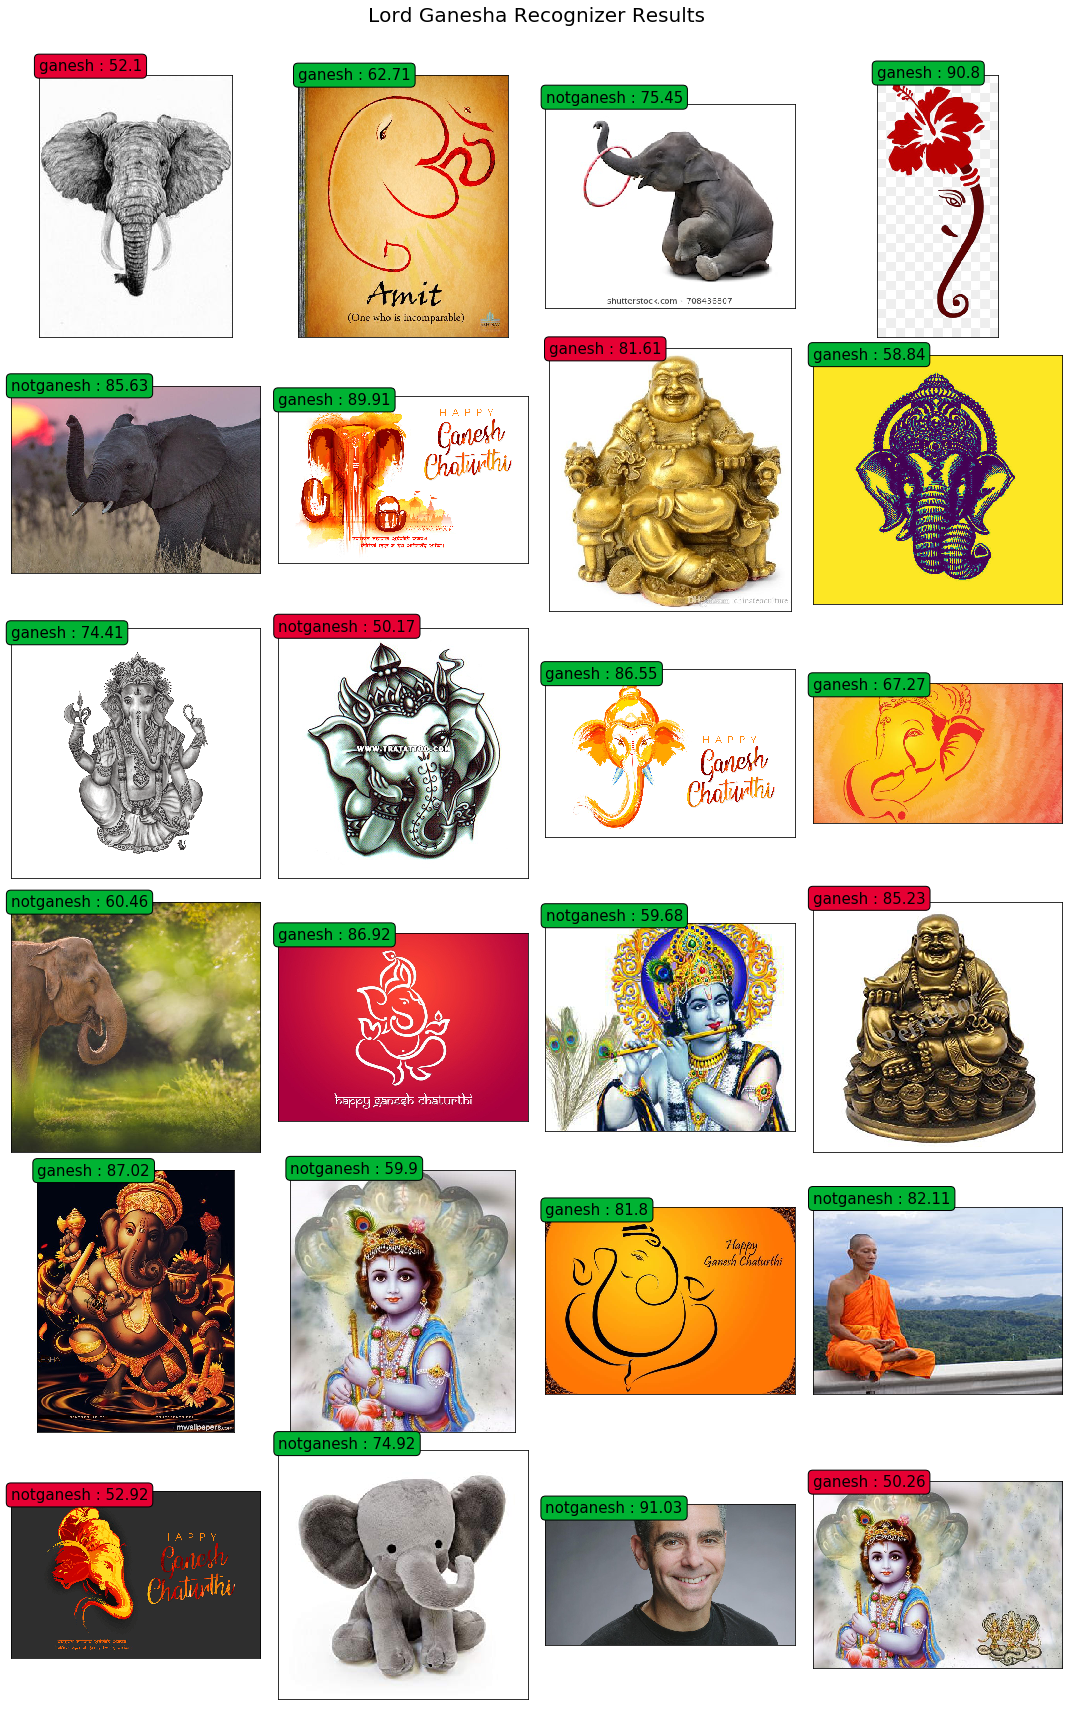

In [16]:
#show results on random test images
rows = len(testImagesPrediction)//4
cols = 4
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Lord Ganesha Recognizer Results', fontsize=20)

for row in range(rows):
    for col in range(cols):
        img_path = testImagesPrediction[row * cols + col][0]
        img = plt.imread(img_path)
        label = testImagesPrediction[row * cols + col][1][0]
        proba = round(testImagesPrediction[row * cols + col][1][1], 2)
        iscorrect = testImagesPrediction[row * cols + col][1][2]
        ax[row][col].imshow(img)
        fc = (0, .7, .2) if iscorrect else (0.9, 0, .2)
        ax[row][col].text(0, -20, '{} : {}'.format(label, proba), size=15, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### 9. Summary

Lord Ganesha is worshipped in many parts of the world as God of intellect and wisdom and also known as the patron of arts and sciences. Sep 13 is Ganesh chaturdi, a festival celebrated as the birth of Ganesha. On this auspicious day, I want to offer my gratitude to Lord Ganesha by building a simple deep learning model that recognizes Ganesha images. I prototyped this model very fast but I am able to achieve an accuracy score of around 80%.  I have used Convolution neural networks for achieving this image classification task. The improvements that can be made for better accuracy, are trying different optimizers, increasing more layers and changing the stride and learning rate.

I have used googleimagesdownload package for obtaining the data, used two classes for training 'ganesh'(most of the images that belong to this class are Lord Ganesh portraits in sitting posture) and 'notganesh'(used person images, also some other Hindu god images).  I have augmented the images since the data size is small. I have used 'Adem' as an optimizer for model. The architecture of the CNN model is pretty simple(at least I am thinking). 

**Tricking the model:**
    
Lord Ganesh has a very peculiar feature, he has an elephant head(resembling the big brain, great intelligence), so it is not surprising for me that model learned that feature pretty well. I have purposefully not given elephant images in 'notganesh' class, I am in an assumption that model will fail for Elephant images, to my surprise, it did pretty good, you can see it in the results section(but the first image in tricky). The model failed for all 'laughing budda' images(technically speaking laughing buddha is known as Chinese Ganesha I don't know how my model knows this), the reason that I can think of is, most of the images under 'ganesh' label have sitting postures of Ganesha, so the model might have confused with the same sitting posture of 'laughing budda'. One other image that model got confused with is with the black and white image in third row second one.  I am assuming that the trunk of the head is curly, so it has mistaken it as not Ganesha. Overall it is a good learning experience for me and I am very satisfied that I have offered prayers to Lord Ganesha in this manner.

I would like to know your valuable feedback and suggestion, you can connect me on: 
 
* [LinkedIn](https://www.linkedin.com/in/vinaydatta2020/)
* [Twitter](https://twitter.com/vinay4B7)
